<a href="https://colab.research.google.com/github/EugIva/ProzorovEI209M_CV/blob/main/HW3_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задача №2 - Реализовать Image-blending на основе сшивки по градиентам

Задача - взять фото двух лиц : ваше и друга, с помощью метода Poisson image editing совместить глаза, нос и рот с первого изображения со вторым. Суть в том, что при использовании такого метода границы совмещенного изображения не видны.

используя более точные методы для определения областей лица (глаз, носа, рта) и создания масок возбму `dlib` для обнаружения ключевых точек лица.
Надо скачать предобученную модель для обнаружения ключевых точек лица:
    `shape_predictor_68_face_landmarks.dat` (http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2)

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [33]:
def load_cascade(cascade_path):
    """Загружает каскад Хаара из указанного пути."""
    cascade = cv2.CascadeClassifier(cascade_path)
    if cascade.empty():
        raise ValueError(f"Не удалось загрузить каскад Хаара по пути {cascade_path}")
    return cascade

def load_image(img_path):
    """Загружает изображение из указанного пути."""
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение по пути {img_path}")
    return img

def detect_face_parts(img, face_cascade, eye_cascade, nose_cascade, mouth_cascade):
    """Обнаруживает части лица на изображении и создает маску."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    mask = np.zeros_like(gray)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]

        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex, ey, ew, eh) in eyes:
            cv2.ellipse(mask, ((ex + ew//2 + x), (ey + eh//2 + y)), (ew//2, eh//2), 0, 0, 360, 255, -1)

        nose = nose_cascade.detectMultiScale(roi_gray)
        for (nx, ny, nw, nh) in nose:
            cv2.ellipse(mask, ((nx + nw//2 + x), (ny + nh//2 + y)), (nw//2, nh//2), 0, 0, 360, 255, -1)

        mouth = mouth_cascade.detectMultiScale(roi_gray)
        for (mx, my, mw, mh) in mouth:
            cv2.ellipse(mask, ((mx + mw//2 + x), (my + mh//2 + y)), (mw//2, mh//2), 0, 0, 360, 255, -1)

    return img, mask

def resize_image(img, target_size):
    """Изменяет размер изображения до целевого размера."""
    return cv2.resize(img, target_size)

def display_images(images, titles):
    """Отображает изображения с указанными заголовками."""
    fig, axes = plt.subplots(1, len(images), figsize=(15, 10))
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis('off')
    plt.show()


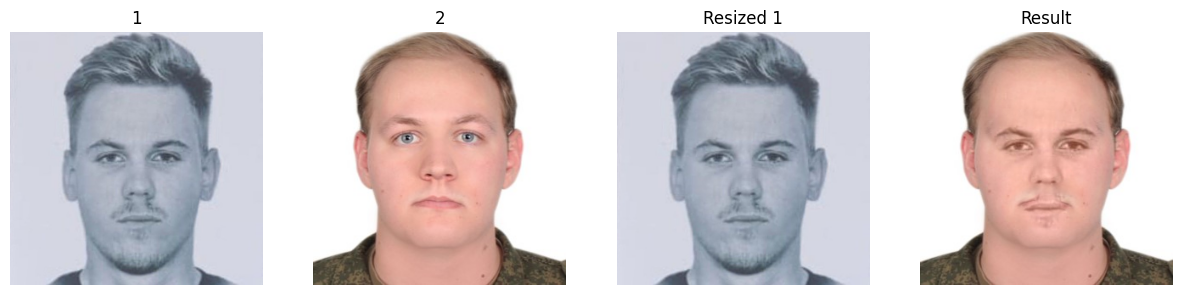

In [43]:
def main():
    # Загрузка каскадов Хаара
    eye_cascade = load_cascade(cv2.data.haarcascades + 'haarcascade_eye.xml')
    nose_cascade = load_cascade('haarcascade_mcs_nose.xml')
    mouth_cascade = load_cascade('haarcascade_mcs_mouth.xml')
    face_cascade = load_cascade(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Загрузка изображений
    src_img = load_image("face1.jpg")
    dst_img = load_image("face2.jpg")

    # Обнаружение частей лица и создание масок
    src_img, src_mask = detect_face_parts(src_img, face_cascade, eye_cascade, nose_cascade, mouth_cascade)
    dst_img, dst_mask = detect_face_parts(dst_img, face_cascade, eye_cascade, nose_cascade, mouth_cascade)

    # Изменение размера изображений
    target_size = (dst_img.shape[1], dst_img.shape[0])
    src_resized = resize_image(src_img, target_size)
    src_mask_resized = resize_image(src_mask, target_size)

    # Применение метода seamless cloning
    center = (target_size[0] // 2, target_size[1] // 2)
    seamless_img = cv2.seamlessClone(src_resized, dst_img, src_mask_resized, center, cv2.NORMAL_CLONE)

    # Отображение изображений
    images = [src_img, dst_img, src_resized, seamless_img]
    titles = ['1', '2', 'Resized 1', 'Result']
    display_images(images, titles)
    # Сохранение результата
    cv2.imwrite('Result.jpg', seamless_img)


if __name__ == "__main__":
    main()